# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import string

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

import pickle
from tqdm import tqdm
import os
from collections import Counter

# ============================== loading libraries ===========================================

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

from sklearn.feature_extraction.text import CountVectorizer


In [84]:
import os
os.listdir('.')

['.config',
 'finalized_df_0317.sav',
 'Reviews.csv',
 'kaggle.json',
 'final_0317.pkl',
 'database.sqlite',
 'amazon-fine-food-reviews.zip',
 '.ipynb_checkpoints',
 'drive',
 'hashes.txt',
 'sample_data']

In [85]:
!unzip amazon-fine-food-reviews.zip

Archive:  amazon-fine-food-reviews.zip
replace Reviews.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [86]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [87]:
from google.colab import files
files.upload()

{}

In [0]:
!pip install -q kaggle

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [90]:
!kaggle datasets list

ref                                                          title                                                size  lastUpdated          downloadCount  
-----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
ronitf/heart-disease-uci                                     Heart Disease UCI                                     3KB  2018-06-25 11:33:56          16578  
karangadiya/fifa19                                           FIFA 19 complete player dataset                       2MB  2018-12-21 03:52:59          14276  
russellyates88/suicide-rates-overview-1985-to-2016           Suicide Rates Overview 1985 to 2016                 396KB  2018-12-01 19:18:25          12373  
mohansacharya/graduate-admissions                            Graduate Admissions                                   9KB  2018-12-28 10:07:14          13718  
iarunava/cell-images-for-detecting-malaria                

In [91]:
!kaggle datasets download -d snap/amazon-fine-food-reviews

amazon-fine-food-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [92]:
# using SQLite Table to read data.
con = sqlite3.connect('/content/database.sqlite')

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points
#con = pd.read_csv('content/Reviews.csv')
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [94]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [95]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [96]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [97]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [99]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [100]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [101]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [103]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

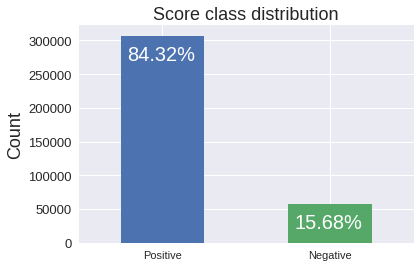

In [104]:
# Code referred from https://stackoverflow.com/questions/31749448/how-to-add-percentages-on-top-of-bars-in-seaborn
ax = final['Score'].value_counts().plot(kind='bar', 
                                         fontsize=13);
ax.set_alpha(0.8)
ax.set_title("Score class distribution", fontsize=18)
ax.set_ylabel("Count", fontsize=18);
#ax.set_yticks([0, 5, 10, 15, 20])
ax.set_xticklabels(['Positive', 'Negative'], rotation=0, fontsize=11)

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_height())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # Decreasing the i.get_x()+.12 will shift the text to left side and decreasing the i.get_height()-14 will bring the text down
    ax.text(i.get_x()+.04, i.get_height()-36000, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=20,
                color='white')

**Observation:** This is an imbalance dataset. There are roughly 84% Positive review and 16% Negative reviews.

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [105]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [106]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [107]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [109]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [110]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [111]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [113]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364171/364171 [02:24<00:00, 2526.48it/s]


In [114]:
preprocessed_reviews[1500]

'great ingredients although chicken rather chicken broth thing not think belongs canola oil canola rapeseed not someting dog would ever find nature find rapeseed nature eat would poison today food industries convinced masses canola oil safe even better oil olive virgin coconut facts though say otherwise late poisonous figured way fix still like could better'

<h2>[3.2] Preprocessing Review Summary</h2>

In [115]:
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|██████████| 364171/364171 [01:34<00:00, 3833.57it/s]


In [0]:
final['CleanedText']= preprocessed_reviews  # Review Text

In [0]:
final['CleanedSummary']= preprocessed_summary # Summary Text

In [118]:
final.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'CleanedText', 'CleanedSummary'],
      dtype='object')

In [0]:
import pickle

In [0]:
# Saving final df to colab

#final.to_pickle('final_0317.pkl')    #to save the dataframe, df to 123.pkl


In [0]:
# Moving pickle file to drive
#!cp /content/final_0317.pkl /content/drive/My\ Drive/Aaic/


In [0]:
# Reading back
#final = pd.read_pickle('final_0317.pkl') #to load 123.pkl back to the dataframe df

In [0]:
#not used

#final = pickle.load(open('finalized_0317.sav', 'rb'))


In [124]:
!ls


amazon-fine-food-reviews.zip  final_0317.pkl	     kaggle.json
database.sqlite		      finalized_df_0317.sav  Reviews.csv
drive			      hashes.txt	     sample_data


In [0]:
# downloading files
#from google.colab import files

#files.download('final_0317.pkl')

In [125]:
final.shape

(364171, 12)

In [126]:
final.CleanedText.isnull().sum()

0

In [127]:
final.CleanedSummary.isnull().sum()

0

In [0]:
# Create X and Y variable 
X = final['CleanedText'].values
y= final['Score'].values

In [129]:
type(X)

numpy.ndarray

In [130]:
type(y)

numpy.ndarray

In [0]:
from sklearn.model_selection import train_test_split

# Splitting into train and test in the ratio 70:30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,shuffle=False, random_state=507)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.30, shuffle=False, random_state=507)

In [132]:
# ss
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)


(178443,) (178443,)
(76476,) (76476,)
(109252,) (109252,)


<font color='red'>In amazon food review dataset our feature importance is words which we get after vectorizations</font>

# [4] Featurization

## [4.1] BAG OF WORDS

In [133]:
# ss
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100)

After vectorizations
(178443, 80067) (178443,)
(76476, 80067) (76476,)
(109252, 80067) (109252,)


In [134]:
print("the type of count vectorizer ",type(X_train_bow))
print("the shape of cut text BOW vectorizer ",X_train_bow.get_shape())
print("the number of unique words: ", X_train_bow.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of cut text BOW vectorizer  (178443, 80067)
the number of unique words:  80067


## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
#count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
#final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
#print("the type of count vectorizer ",type(final_bigram_counts))
#print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
#print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

 <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>

In [0]:
from sklearn.naive_bayes import MultinomialNB

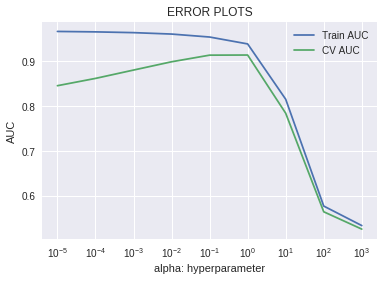


The optimal number of alpha is 1


In [137]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# alpha values
alpha_range = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,1000]

# empty list that will hold cv scores
train_auc = []
cv_auc = []


for a in alpha_range:
    mn_nb = MultinomialNB(alpha= a)
    mn_nb.fit(X_train_bow, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  mn_nb.predict_proba(X_train_bow)[:,1]
    y_cv_pred =  mn_nb.predict_proba(X_cv_bow)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(alpha_range, train_auc, label='Train AUC')
plt.plot(alpha_range, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.xscale('log')
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()




# changing to misclassification error
MSE = [1 - x for x in cv_auc]


# determining best alpha
optimal_alpha_bow_mnnb = alpha_range[MSE.index(min(MSE))]
print('\nThe optimal number of alpha is {}'.format(optimal_alpha_bow_mnnb))


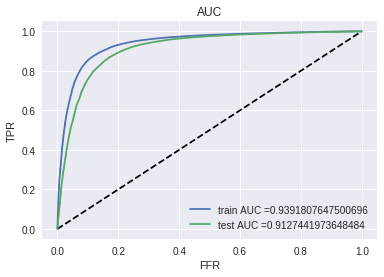

Train confusion matrix
[[ 19633   7332]
 [  7071 144407]]
Test confusion matrix
[[11828  6530]
 [ 4099 86795]]


In [139]:
## ss

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = MultinomialNB(alpha=optimal_alpha_bow_mnnb)
neigh.fit(X_train_bow, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test_bow)[:,1])

plt.plot([0,1],[0,1],'k--')
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FFR")
plt.ylabel("TPR")
plt.title("AUC")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(X_train_bow)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(X_test_bow)))

In [0]:
auc_train_bow_mnnb = auc(train_fpr, train_tpr)
auc_test_bow_mnnb = auc(test_fpr, test_tpr)

In [0]:
# Get the confusion matrix
from sklearn.metrics import classification_report


# Code modified from sklearn tutorial: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #if normalize:
     #   cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
     #   print("Normalized confusion matrix")
    #else:
      #  print('Confusion matrix')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


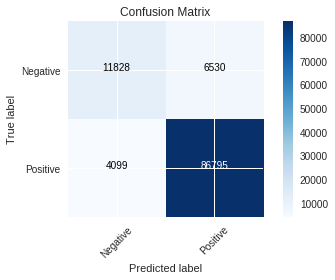

In [142]:
cnf_matrix = confusion_matrix(y_test, neigh.predict(X_test_bow))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix');

In [143]:
neigh.classes_

array([0, 1])

In [0]:
# This code has been referred from https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers#answer-50810751

def important_features(vectorizer,classifier,n=10):
    
    """
    This function takes in the vectorizer, classifer and the number of words required.
    Returns the top feature names along with their coeffiecent
    """
    from prettytable import PrettyTable
    t1 = PrettyTable()
    t2 = PrettyTable()
    
    t1.field_names= ['class','feature', 'importance']
    t2.field_names= ['class','feature', 'importance']
    
    class_labels = classifier.classes_
    feature_names =vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.feature_log_prob_[0], feature_names),reverse=True)[:n] 
    topn_class2 = sorted(zip(classifier.feature_log_prob_[1], feature_names),reverse=True)[:n]
    
    print("Important words in negative reviews")
    for coef, feat in topn_class1:
        t1.add_row([class_labels[0], feat, abs(coef)])
    print(t1)
    
    print('*' * 32)
    
    print("Important words in positive reviews")
    for coef, feat in topn_class2:
        t2.add_row([class_labels[1], feat, abs(coef)])       
    print(t2)
        
    #print("-----------------------------------------")
    #print("Important words in positive reviews")
    #for coef, feat in topn_class2:
     #   print(class_labels[1], coef, feat)

In [145]:
important_features(vectorizer, neigh)

Important words in negative reviews
+-------+---------+-------------------+
| class | feature |     importance    |
+-------+---------+-------------------+
|   0   |   not   | 3.352726827355946 |
|   0   |   like  | 4.529139529519954 |
|   0   | product |  4.70843747661416 |
|   0   |  would  | 4.770125134223722 |
|   0   |  taste  | 4.826104401965624 |
|   0   |   one   | 4.920265816566076 |
|   0   |    no   | 5.191023415679439 |
|   0   |   good  | 5.191926894132704 |
|   0   |   tea   | 5.298493318890541 |
|   0   |  flavor | 5.332412207447838 |
+-------+---------+-------------------+
********************************
Important words in positive reviews
+-------+---------+--------------------+
| class | feature |     importance     |
+-------+---------+--------------------+
|   1   |   not   | 3.7698863943340104 |
|   1   |   like  | 4.638346408821736  |
|   1   |   good  | 4.709338927181472  |
|   1   |  great  | 4.737199069831567  |
|   1   |   tea   | 4.862455589694864  |
|   1  

**Observation:**
1. For the BoW vectorizer, we optimal value of alpha we got is 1.
2. The AUC for test data is quite high (~91%)
3. We can some important features are common in both the reviews; positive and negative.
4. The confusion matrix shows the classification. It shows we correctly classified 86795 positive reviews and 11828 negative reviews. 

## [4.3] TF-IDF

In [146]:
# ss
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = tf_idf_vect.transform(X_train)
X_cv_tfidf = tf_idf_vect.transform(X_cv)
X_test_tfidf = tf_idf_vect.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)
print("="*100)

After vectorizations
(178443, 99725) (178443,)
(76476, 99725) (76476,)
(109252, 99725) (109252,)


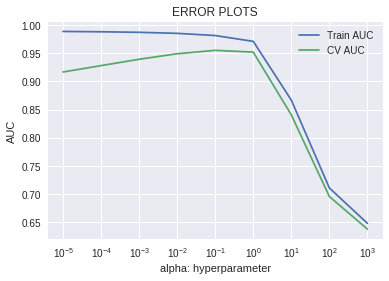


The optimal number of alpha is 0.1


In [147]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# alpha values
alpha_range = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,1000]

# empty list that will hold cv scores
train_auc = []
cv_auc = []


for a in alpha_range:
    mn_nb = MultinomialNB(alpha= a)
    mn_nb.fit(X_train_tfidf, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  mn_nb.predict_proba(X_train_tfidf)[:,1]
    y_cv_pred =  mn_nb.predict_proba(X_cv_tfidf)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(alpha_range, train_auc, label='Train AUC')
plt.plot(alpha_range, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.xscale('log')
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()




# changing to misclassification error
MSE = [1 - x for x in cv_auc]


# determining best alpha
optimal_alpha_tfidf_mnnb = alpha_range[MSE.index(min(MSE))]
print('\nThe optimal number of alpha is {}'.format(optimal_alpha_tfidf_mnnb))


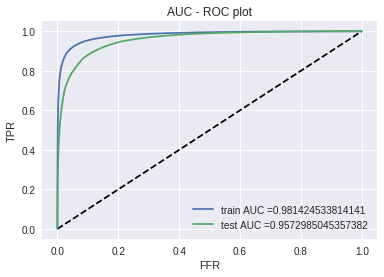

Train confusion matrix
[[ 18834   8131]
 [  1983 149495]]
Test confusion matrix
[[10077  8281]
 [ 1176 89718]]


In [148]:
## ss

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


optimal_alpha_tfidf = MultinomialNB(alpha=optimal_alpha_tfidf_mnnb)
optimal_alpha_tfidf.fit(X_train_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, optimal_alpha_tfidf.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, optimal_alpha_tfidf.predict_proba(X_test_tfidf)[:,1])

plt.plot([0,1],[0,1],'k--')
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FFR")
plt.ylabel("TPR")
plt.title("AUC - ROC plot")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, optimal_alpha_tfidf.predict(X_train_tfidf)))
print("Test confusion matrix")
print(confusion_matrix(y_test, optimal_alpha_tfidf.predict(X_test_tfidf)))

In [0]:
auc_train_tfidf_mnnb = auc(train_fpr, train_tpr)
auc_test_tfidf_mnnb = auc(test_fpr, test_tpr)

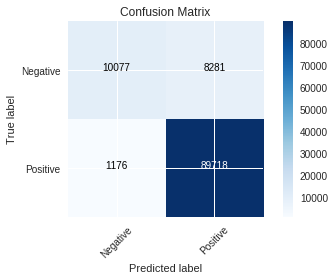

In [150]:
cnf_matrix = confusion_matrix(y_test, optimal_alpha_tfidf.predict(X_test_tfidf))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix');

In [151]:
important_features(tf_idf_vect, optimal_alpha_tfidf)

Important words in negative reviews
+-------+---------+--------------------+
| class | feature |     importance     |
+-------+---------+--------------------+
|   0   |   not   | 4.9299176851900794 |
|   0   |   like  | 5.782091332279363  |
|   0   | product | 5.811530955014628  |
|   0   |  would  | 5.894882831191134  |
|   0   |  taste  | 5.903203138089251  |
|   0   |   one   | 6.127316678033396  |
|   0   |    no   | 6.251209363175992  |
|   0   |   tea   | 6.291378149001668  |
|   0   |  flavor | 6.370895063231856  |
|   0   |   good  | 6.394922571770179  |
+-------+---------+--------------------+
********************************
Important words in positive reviews
+-------+---------+--------------------+
| class | feature |     importance     |
+-------+---------+--------------------+
|   1   |   not   | 5.480920305432166  |
|   1   |  great  | 5.809191289843023  |
|   1   |   tea   | 5.870564605851304  |
|   1   |   good  | 5.887065857732393  |
|   1   |   like  |  5.98377367270

**Observation:**
1. For the TFIDF vectorizer, we optimal value of alpha we got is 0.1.
2. The AUC for test data is quite high (~95%)
3. We can some important features are common in both the reviews; positive and negative.
4. The confusion matrix shows the classification. It shows we correctly classified 89718 positive reviews and 10077 negative reviews. 

**Feature Engineering:** For feature engineering we will append lenght of reviews the vectorized text.

**Finding length of review Text**

In [0]:
# Create X and Y variable 
X2 = final['CleanedText'].values  #,  'CleanedSummary']].values
y2 = final['Score'].values
#rev_len = final['ReviewTextLength'].values

In [0]:
from sklearn.model_selection import train_test_split

# Splitting into train and test in the ratio 70:30
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.30,shuffle=False, random_state=507)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.30, shuffle=False, random_state=507)

In [154]:
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

(178443,) (178443,)
(76476,) (76476,)
(109252,) (109252,)


**Free-up space by deleting variables that are not required from this point onwards**

In [0]:
del actualScore, positiveNegative, filtered_data, display,sorted_data, final, sent_0, sent_1000, sent_150, sent_4900, soup, text, sent_1500, X, y, train_auc, cv_auc, MSE, vectorizer, neigh, cnf_matrix, X2, y2

In [0]:
# https://stackoverflow.com/questions/18691084/what-does-1-mean-in-numpy-reshape

def get_text_length(x):
    
    """
    This function takes in a array and returns the length of the elements in the array.
    """
    return np.array([len(t) for t in x]).reshape(-1, 1)

In [0]:
rev_len_X_train = get_text_length(X_train)
rev_len_X_cv = get_text_length(X_cv)
rev_len_X_test = get_text_length(X_test)

In [158]:
print(len(rev_len_X_train))
print(len(rev_len_X_cv))
print(len(rev_len_X_test))

178443
76476
109252


**BoW with Feature Engineering**

In [159]:
# ss
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train) # fit has to happen only on train data

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [160]:
type(rev_len_X_train)

numpy.ndarray

In [161]:
type(X_train_bow)

scipy.sparse.csr.csr_matrix

In [0]:
from scipy.sparse import hstack

# Here we append the sparse matrix and the dense array that contains the length of the text passed to it

xltf = hstack((X_train_bow, np.array(rev_len_X_train)))

xltf_cv = hstack((X_cv_bow, np.array(rev_len_X_cv)))

xltf_test = hstack((X_test_bow, np.array(rev_len_X_test)))

In [0]:
from sklearn.naive_bayes import MultinomialNB

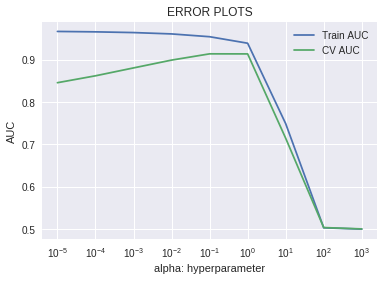


The optimal number of alpha is 0.1


In [164]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# alpha values
alpha_range = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,1000]

# empty list that will hold cv scores
train_auc = []
cv_auc = []


for a in alpha_range:
    mn_nb = MultinomialNB(alpha= a)
    mn_nb.fit(xltf, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  mn_nb.predict_proba(xltf)[:,1]
    y_cv_pred =  mn_nb.predict_proba(xltf_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(alpha_range, train_auc, label='Train AUC')
plt.plot(alpha_range, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.xscale('log')
plt.title("ERROR PLOTS")
plt.show()




# changing to misclassification error
MSE = [1 - x for x in cv_auc]


# determining best alpha
optimal_alpha_bow2_mnnb = alpha_range[MSE.index(min(MSE))]
print('\nThe optimal number of alpha is {}'.format(optimal_alpha_bow2_mnnb))


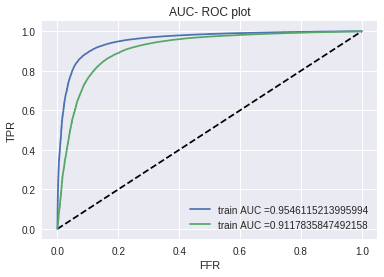

Train confusion matrix
[[ 21547   5418]
 [  7770 143708]]
Test confusion matrix
[[12703  5655]
 [ 5505 85389]]


In [165]:
## ss

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = MultinomialNB(alpha=optimal_alpha_bow2_mnnb)
neigh.fit(xltf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(xltf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(xltf_test)[:,1])

plt.plot([0,1],[0,1],'k--')
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FFR")
plt.ylabel("TPR")
plt.title("AUC- ROC plot")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(xltf)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(xltf_test)))

In [0]:
auc_train_bow2_mnnb = auc(train_fpr, train_tpr)
auc_test_bow2_mnnb = auc(test_fpr, test_tpr)

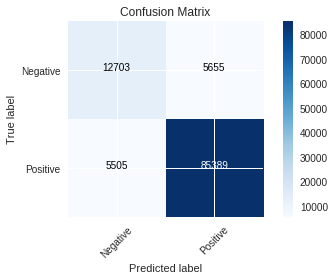

In [167]:
cnf_matrix = confusion_matrix(y_test, neigh.predict(xltf_test))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix');

In [168]:
important_features(vectorizer,neigh)

Important words in negative reviews
+-------+---------+--------------------+
| class | feature |     importance     |
+-------+---------+--------------------+
|   0   |   not   | 5.3055941944631755 |
|   0   |   like  | 6.482055229862741  |
|   0   | product | 6.661366901081326  |
|   0   |  would  | 6.723059878896089  |
|   0   |  taste  | 6.779044266974202  |
|   0   |   one   | 6.873214968110277  |
|   0   |    no   |   7.14400470212    |
|   0   |   good  | 7.144908303030867  |
|   0   |   tea   | 7.2514899765280845 |
|   0   |  flavor | 7.285414069608427  |
+-------+---------+--------------------+
********************************
Important words in positive reviews
+-------+---------+-------------------+
| class | feature |     importance    |
+-------+---------+-------------------+
|   1   |   not   | 5.770965303803038 |
|   1   |   like  | 6.639434786291659 |
|   1   |   good  | 6.710428504843417 |
|   1   |  great  | 6.738289142271407 |
|   1   |   tea   | 6.863548065095065 |
|

**Observation:**
1. For the BoW vectorizer, we performed feature engineering and the optimal value of alpha we got is 0.1.
2. The AUC for test data is quite high (~91%)
3. We can some important features are common in both the reviews; positive and negative.
4. The confusion matrix shows the classification. It shows we correctly classified 86389 positive reviews and 12703 negative reviews. 

**TFIDF of with feature engineering**

In [169]:
# ss
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = tf_idf_vect.transform(X_train)
X_cv_tfidf = tf_idf_vect.transform(X_cv)
X_test_tfidf = tf_idf_vect.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)
print("="*100)

After vectorizations
(178443, 99725) (178443,)
(76476, 99725) (76476,)
(109252, 99725) (109252,)


In [0]:
xltf_tfidf = hstack((X_train_tfidf, np.array(rev_len_X_train)))

xltf_cv_tfidf = hstack((X_cv_tfidf, np.array(rev_len_X_cv)))

xltf_test_tfidf = hstack((X_test_tfidf, np.array(rev_len_X_test)))

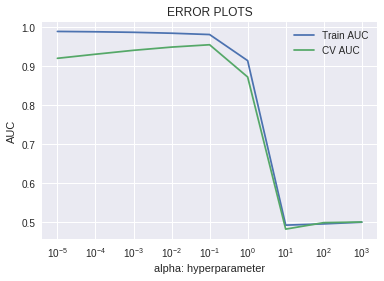


The optimal number of alpha is 0.1


In [172]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# alpha values
alpha_range = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,1000]

# empty list that will hold cv scores
train_auc = []
cv_auc = []


for a in alpha_range:
    mn_nb = MultinomialNB(alpha= a)
    mn_nb.fit(xltf_tfidf, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  mn_nb.predict_proba(xltf_tfidf)[:,1]
    y_cv_pred =  mn_nb.predict_proba(xltf_cv_tfidf)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(alpha_range, train_auc, label='Train AUC')
plt.plot(alpha_range, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.xscale('log')
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()




# changing to misclassification error
MSE = [1 - x for x in cv_auc]


# determining best alpha
optimal_alpha_tfidf2_mnnb = alpha_range[MSE.index(min(MSE))]
print('\nThe optimal number of alpha is {}'.format(optimal_alpha_tfidf2_mnnb))


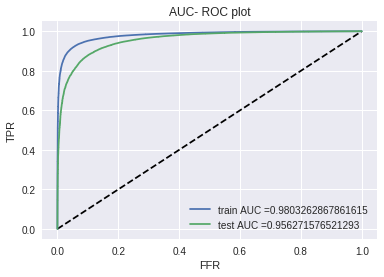

Train confusion matrix
[[ 18838   8127]
 [  2263 149215]]
Test confusion matrix
[[10231  8127]
 [ 1368 89526]]


In [192]:
## ss

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


optimal_alpha_tfidf = MultinomialNB(alpha=optimal_alpha_tfidf2_mnnb)
optimal_alpha_tfidf.fit(xltf_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, optimal_alpha_tfidf.predict_proba(xltf_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, optimal_alpha_tfidf.predict_proba(xltf_test_tfidf)[:,1])

plt.plot([0,1],[0,1],'k--')
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FFR")
plt.ylabel("TPR")
plt.title("AUC- ROC plot")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, optimal_alpha_tfidf.predict(xltf_tfidf)))
print("Test confusion matrix")
print(confusion_matrix(y_test, optimal_alpha_tfidf.predict(xltf_test_tfidf)))

In [0]:
auc_train_tfidf2_mnnb = auc(train_fpr, train_tpr)
auc_test_tfidf2_mnnb = auc(test_fpr, test_tpr)

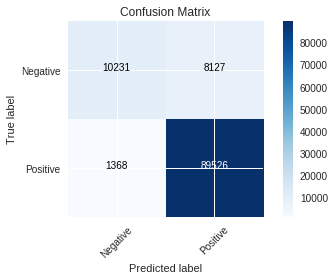

In [194]:
cnf_matrix = confusion_matrix(y_test, optimal_alpha_tfidf.predict(xltf_test_tfidf))
np.set_printoptions(precision=2)
class_names = ['Negative', 'Positive']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix');

In [195]:
important_features(tf_idf_vect,optimal_alpha_tfidf)

Important words in negative reviews
+-------+---------+--------------------+
| class | feature |     importance     |
+-------+---------+--------------------+
|   0   |   not   | 8.686746936902168  |
|   0   |   like  |  9.53892058399145  |
|   0   | product | 9.568360206726716  |
|   0   |  would  |  9.65171208290322  |
|   0   |  taste  | 9.660032389801337  |
|   0   |   one   | 9.884145929745483  |
|   0   |    no   | 10.008038614888079 |
|   0   |   tea   | 10.048207400713755 |
|   0   |  flavor | 10.127724314943944 |
|   0   |   good  | 10.151751823482266 |
+-------+---------+--------------------+
********************************
Important words in positive reviews
+-------+---------+-------------------+
| class | feature |     importance    |
+-------+---------+-------------------+
|   1   |   not   | 9.197896407951081 |
|   1   |  great  | 9.526167392361938 |
|   1   |   tea   |  9.58754070837022 |
|   1   |   good  | 9.604041960251308 |
|   1   |   like  | 9.700749775222645 |
|

**Observation:**
1. For the TFIDF vectorizer, we performed feature engineering and the optimal value of alpha we got is 0.1.
2. The AUC for test data is quite high (~95%)
3. We can some important features are common in both the reviews; positive and negative.
4. The confusion matrix shows the classification. It shows we correctly classified 89526 positive reviews and 10231 negative reviews. 

**Summary**

In [0]:
from prettytable import PrettyTable

In [0]:
del t1

In [0]:
t1 = PrettyTable()
t1.field_names = ['Sr. No', 'Vectorizer', 'Feature Engineering', 'Optimal alpha', 'AUC Train','AUC Test']

In [0]:
t1.add_row([1, 'BoW', 0, optimal_alpha_bow_mnnb, auc_train_bow_mnnb,auc_test_bow_mnnb])
t1.add_row([2, 'TF-IDF', 0, optimal_alpha_tfidf_mnnb, auc_train_tfidf_mnnb, auc_test_tfidf_mnnb])
t1.add_row([3, 'BoW', 1, optimal_alpha_bow2_mnnb, auc_train_bow2_mnnb,auc_test_bow2_mnnb])
t1.add_row([4, 'TF-IDF',1, optimal_alpha_tfidf2_mnnb, auc_train_tfidf2_mnnb, auc_test_tfidf2_mnnb])

In [200]:
print(t1)

+--------+------------+---------------------+---------------+--------------------+--------------------+
| Sr. No | Vectorizer | Feature Engineering | Optimal alpha |     AUC Train      |      AUC Test      |
+--------+------------+---------------------+---------------+--------------------+--------------------+
|   1    |    BoW     |          0          |       1       | 0.9391807647500696 | 0.9127441973648484 |
|   2    |   TF-IDF   |          0          |      0.1      | 0.981424533814141  | 0.9572985045357382 |
|   3    |    BoW     |          1          |      0.1      | 0.9546115213995994 | 0.9117835847492158 |
|   4    |   TF-IDF   |          1          |      0.1      | 0.9803262867861615 | 0.956271576521293  |
+--------+------------+---------------------+---------------+--------------------+--------------------+


**Conclusion**

1. We performed Naive Bayes on BoW and TF-IDF with and without feature engineering and it is evident that latter performed better. 
2. Naive Bayes is simple algorithm which is used in benchmarking. 
3. It should be notes that Naive Bayes assumes that the features are independent of each other. This may not be true in real world. 
4. Different alpha value for BoW and TFIDF is obtained here and their results are also different.
5. The area under curve for both Train and Test data is quite good.
6. Naive Bayes is faster compared to KNN. 

**Why Multinomial Naive Bayes**: It uses word count and can be used with BoW and TFIDF